In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.feature_extraction import DictVectorizer
import scipy
from scipy.sparse import csr_matrix
import json

datasets_folder = 'data/datasets'
results_folder='data/results/withheld_disease_eval'

model_name='UTH'
experiment='pri_ref'
dataset='test' # dev or test
number_of_classes=4
window_before_diagnosis=8
window_after_diagnosis=0
dtype='float32'
C=0.000001 # SVM hyperparameter

# these labels match https://hhsrvmlr1.rvc.ac.uk:8888/notebooks/fp/False%20positives%20-%20CNN%20-%20Dataset%20production.ipynb
class_labels={
    0: '1-never diagnosed',
    1: '2-prior to diagnostic window',
    2: '3-after diagnostic window',
    3: '4-during diagnostic window'}

In [2]:
# the x dataset persistance
# we are using sparse matrices here, so need to save/load in a special way

#https://stackoverflow.com/questions/8955448/save-load-scipy-sparse-csr-matrix-in-portable-data-format

import numpy as np

def save_sparse_csr(filename, array):
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

def load_dataset(dataset='train',number_of_classes=4,window_before_diagnosis=8,window_after_diagnosis=0):
    # dont need the x sets
    #x_1=np.load(datasets_folder+'/x_%s_1_exp_%s.npy' % (dataset,experiment))
    #x_2=np.load(datasets_folder+'/x_%s_2_exp_%s.npy' % (dataset,experiment))
    y_ref=np.load(datasets_folder+'/y_%s_exp_8_classes_%s_window_before_diagnosis_%s_window_after_diagnosis_%s.npy' % 
            (dataset,number_of_classes,window_before_diagnosis,window_after_diagnosis))
    y_pri=np.load(datasets_folder+'/y_%s_exp_9_classes_%s_window_before_diagnosis_%s_window_after_diagnosis_%s.npy' % 
            (dataset,number_of_classes,window_before_diagnosis,window_after_diagnosis))
    return np.vstack([y_ref,y_pri])


In [3]:
def auc(y_test,y_pred):
    import sklearn.metrics
    return sklearn.metrics.roc_auc_score(y_test,y_pred)

def roc(y_test,y_pred, title='Receiver Operating Characteristic'):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.xlabel('1-Specificity (False Positive Rate)')
    plt.show()

def specificity(y_true, y_pred):
    import keras.backend as K 

    # from https://github.com/fchollet/keras/blob/master/keras/metrics.py : matthews_correlation

    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)

    return tn / (tn + fp)

def sensitivity(y_true, y_pred):
    import keras.backend as K 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 1e-07)
    return recall

def ppv(y_true, y_pred):
    import keras.backend as K 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + 1e-07)
    return precision

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import label_ranking_average_precision_score, average_precision_score
from itertools import cycle

def evaluate(y_true, y_pred, plot=True, title='Receiver operating characteristic'):
    
    # first drop any classes without an example in the true labels, AUC is undefined in this case
    num_classes=y_true.shape[1]
    drop_classes=[]
    for i in range(0,num_classes):
        # guard no positive examples, skip them as AUC is undefined in this case
        if sum(y_true[:, i]) == 0:
            drop_classes.append(i)
    
    
    y_true=np.delete(y_true,drop_classes,axis=1)
    y_pred=np.delete(y_pred,drop_classes,axis=1)
    
    if(len(drop_classes)!=0):
        print('dropped %s classes because there were no positive examples in labels (ROC undefined in this case)' % len(drop_classes))
    
    num_classes=y_true.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    if plot:
        # Plot all ROC curves
        plt.figure()
        lw = 2
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
        for i, color in zip(range(num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='{0} area={1:0.2f}'
                     ''.format(class_labels[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()
    return roc_auc



In [4]:
# load persisted training data

x_train=load_sparse_csr('data/datasets/x_train_uth_exp%s.npy.npz' % experiment)
x_test=load_sparse_csr('data/datasets/x_%s_uth_exp%s.npy.npz'  % (dataset,experiment))

# load persisted label data
# need one-hot encoded for evaluation and categorical for training
y_train_4_class_one_hot=load_dataset('train',number_of_classes,window_before_diagnosis,window_after_diagnosis)
y_train_4_class=np.argmax(y_train_4_class_one_hot,axis=1)

y_test_4_class_one_hot=load_dataset(dataset,number_of_classes,window_before_diagnosis,window_after_diagnosis)
y_test_4_class=np.argmax(y_test_4_class_one_hot,axis=1)

# load the study_indices
study_sentence_dictionary_train,study_sentence_dictionary_test=1,1

with open(datasets_folder+'/study_sentence_dictionary_UTH_train_exp_%s.json' % (experiment)) as f:
    study_sentence_dictionary_train = json.load(f)
with open(datasets_folder+'/study_sentence_dictionary_UTH_%s_exp_%s.json' % (dataset, experiment)) as f:
    study_sentence_dictionary_test = json.load(f)

loaded persisted results for 16 studies
study 1937 17/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


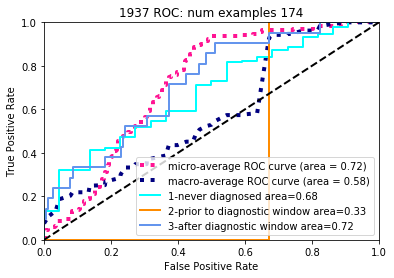

study 1610 18/168


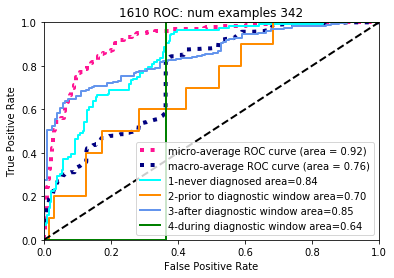

study 466 19/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


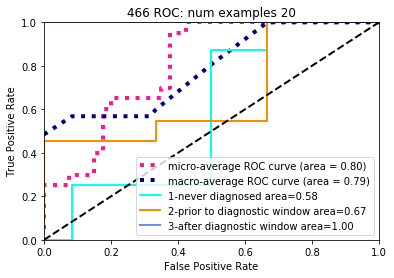

study 1938 20/168


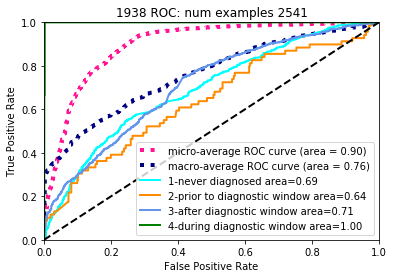

study 18779 21/168


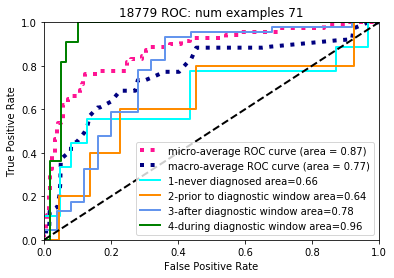

study 20267 22/168


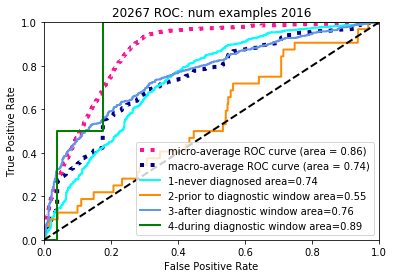

study 625 23/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


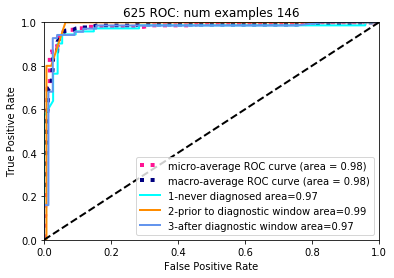

study 2288 24/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


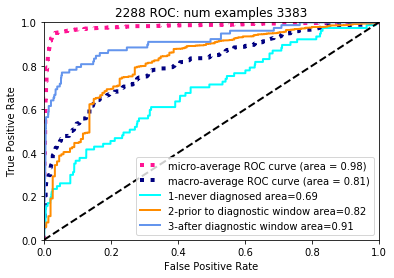

study 7637 25/168


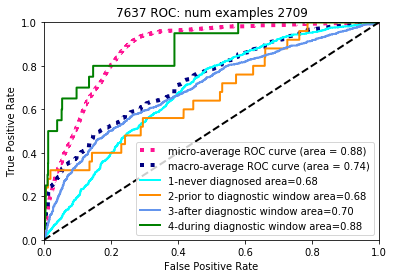

study 5399 26/168


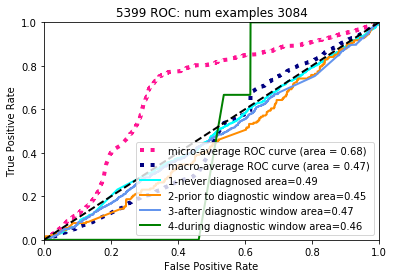

study 79 27/168


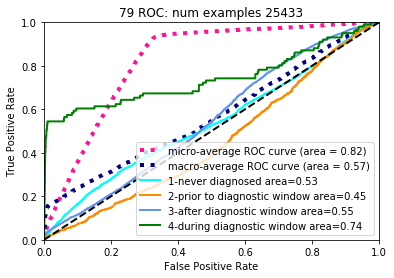

study 65 28/168


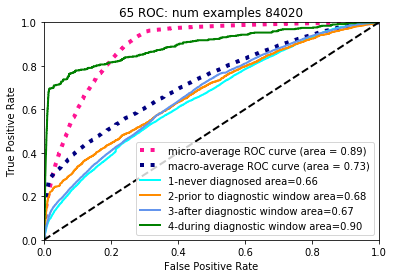

study 1913 29/168


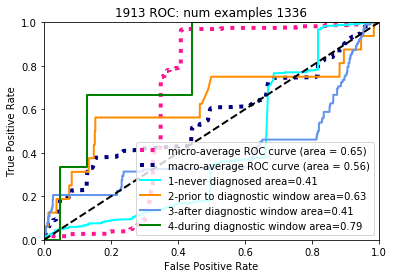

study c580b5cc-ba58-4bf1-8cca-7673d7b47d10 30/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


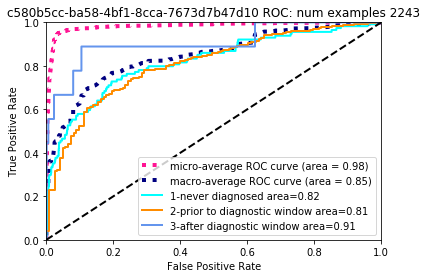

study 1bc06999-e70d-42f1-ac01-5d7ef6d8df4b 31/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


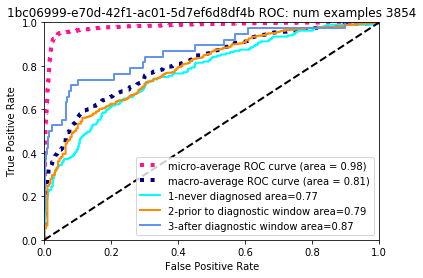

study 0ed9f72a-5b6b-4296-9743-411675d6cd4d 32/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


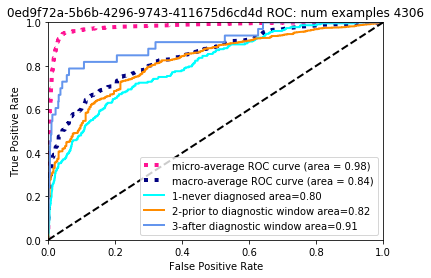

study f6fd297b-7dbb-40f7-90d5-4837c320570f 33/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


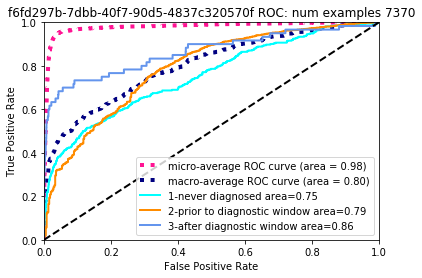

study 1037 34/168


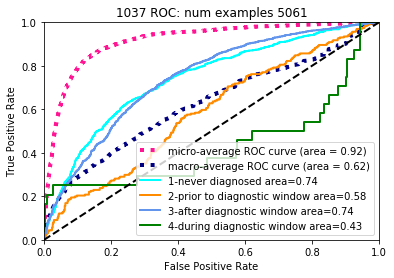

study 93 35/168


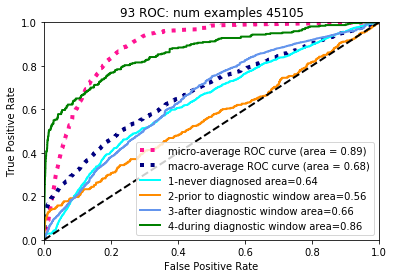

study 1964 36/168


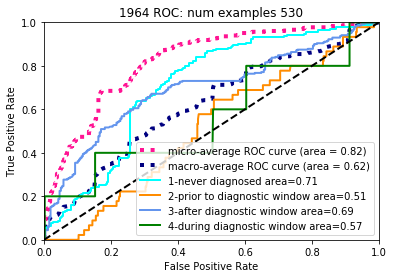

study 506 37/168


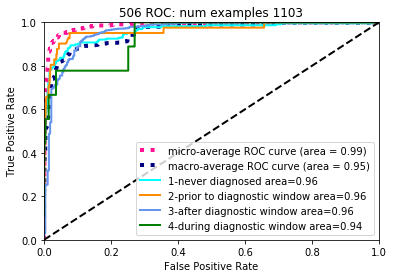

study 1228 38/168


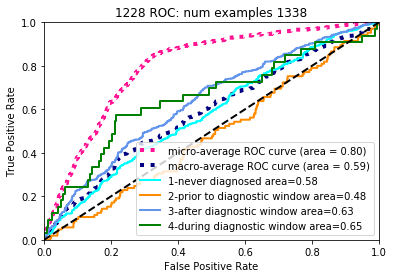

study 2284 39/168


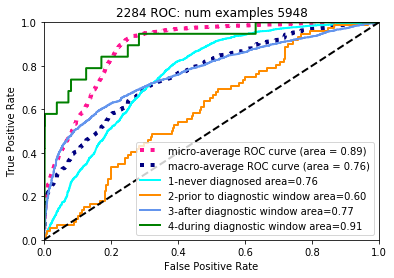

study 17981 40/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


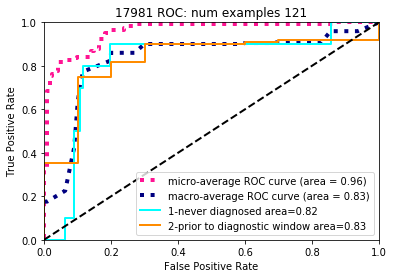

study 2127 41/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


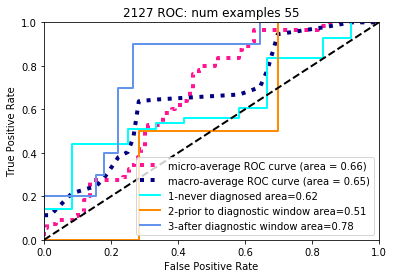

study 2031 42/168


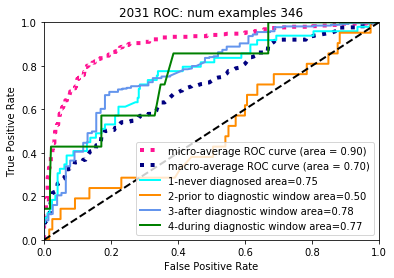

study 1683 43/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


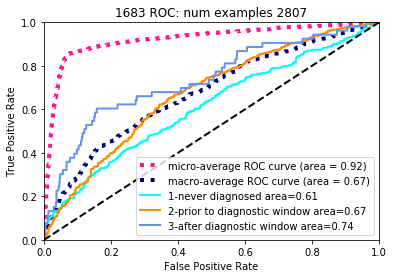

study 350 44/168


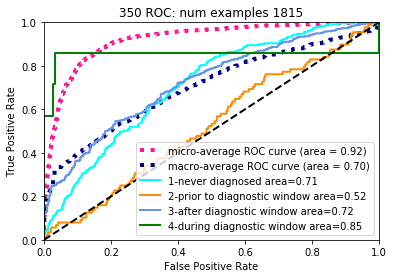

study 1290 45/168


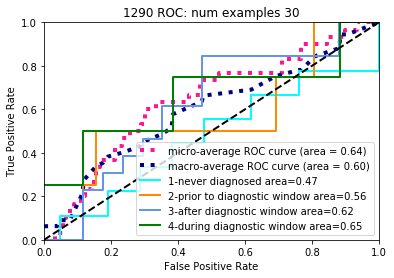

study 518 46/168


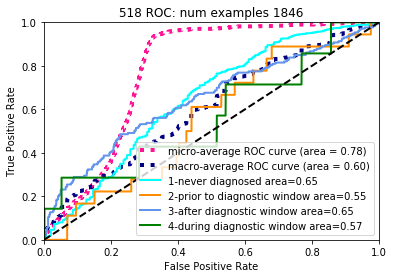

study 2899 47/168


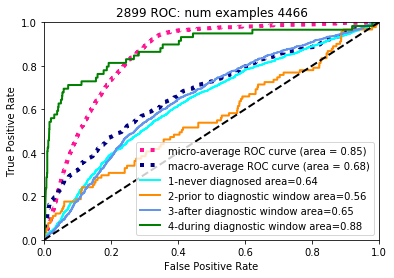

study 708 48/168


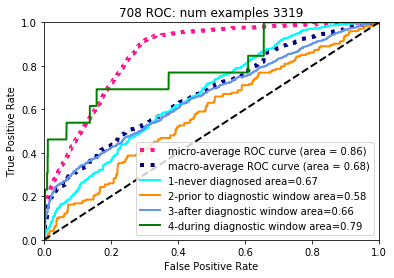

study 5788 49/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


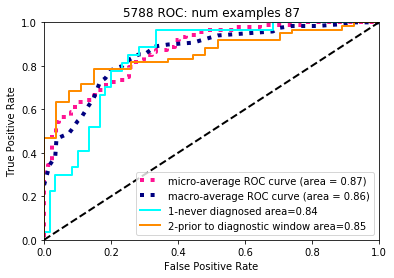

study 528 50/168


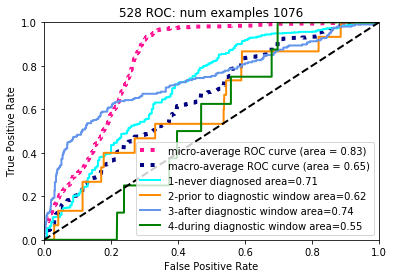

study 2162 51/168


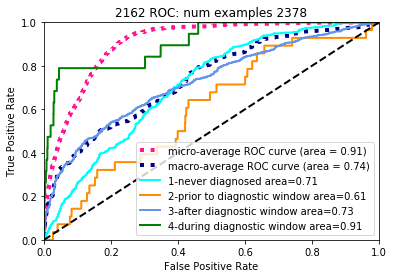

study 7627 52/168


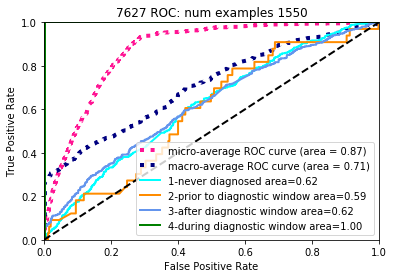

study 895 53/168


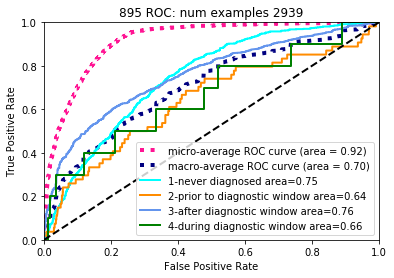

study 1786 54/168


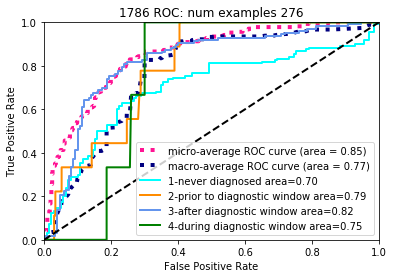

study 74 55/168


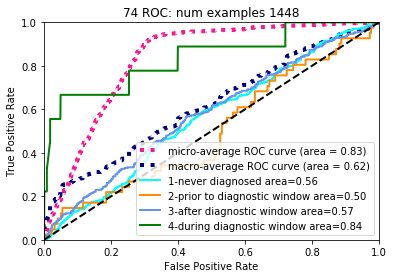

study 4bb814fe-5f8d-417c-a015-9c60767db9c6 56/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


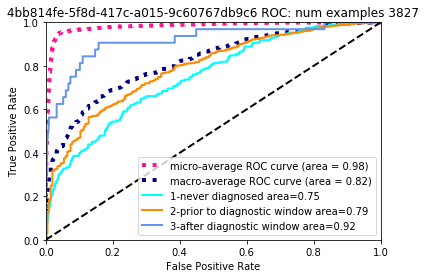

study 1153 57/168


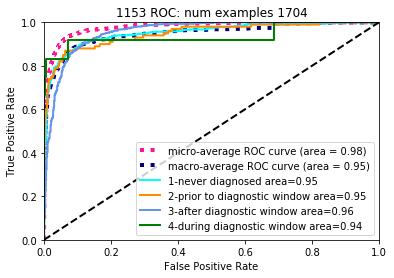

study 1025 58/168


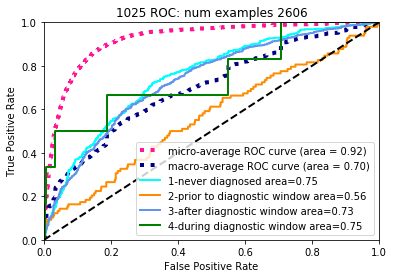

study 999 59/168


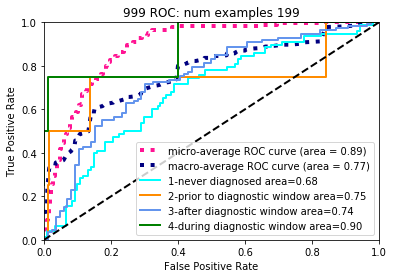

study 2151 60/168


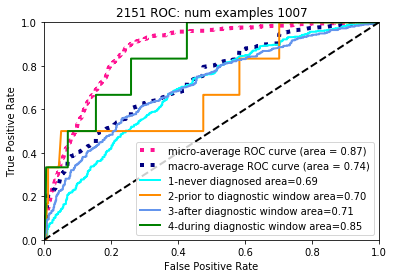

study 718 61/168


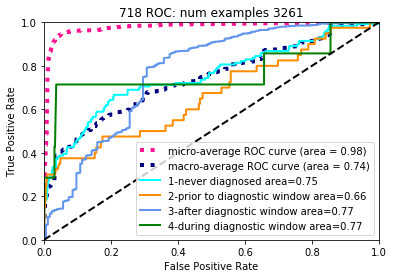

study 62 62/168


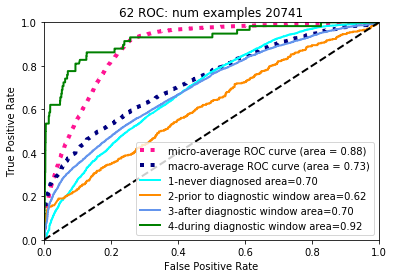

study 057ecdcb-64fc-4f50-ac86-70eea72301ff 63/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


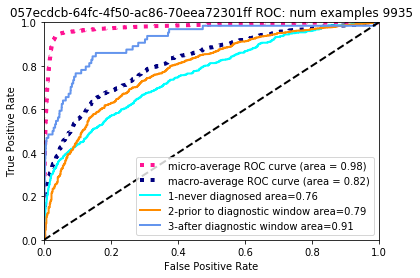

study 7516 64/168


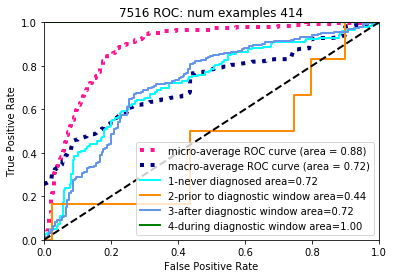

study 921 65/168


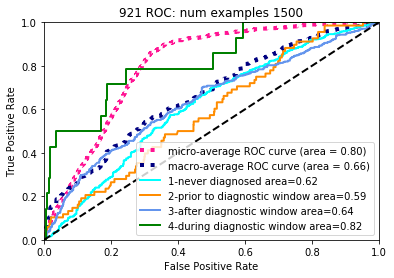

study 7573 66/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


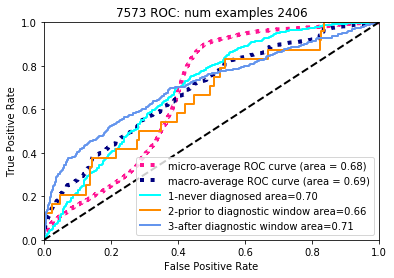

study 511 67/168


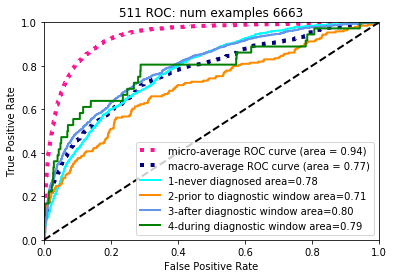

study 2083 68/168


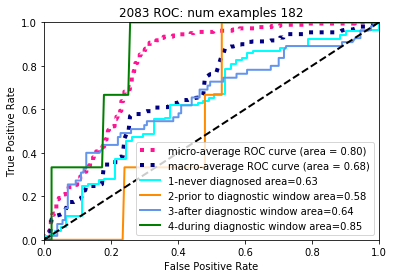

study 4e278045-23d2-46e7-9c39-748b9600d694 69/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


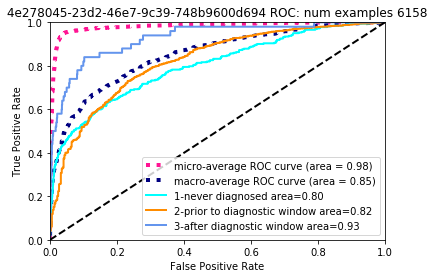

study 684 70/168


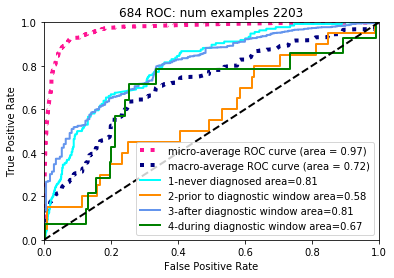

study 1287 71/168


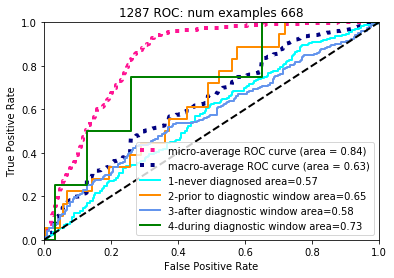

study 4fc3c861-922d-4e9b-af96-9b224e5952d9 72/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


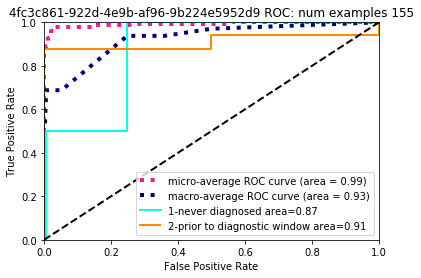

study 8425ec75-183e-4281-adb0-ba5d27947bd3 73/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


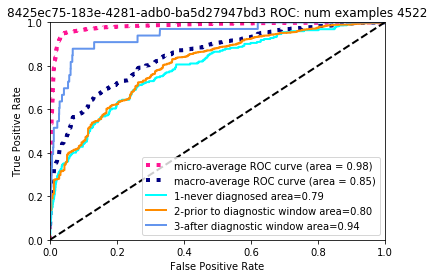

study 963 74/168


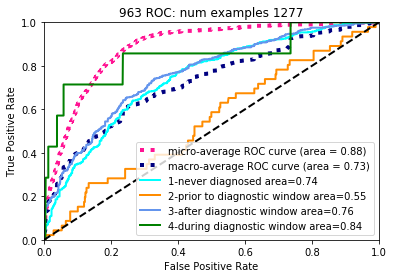

study 90 75/168


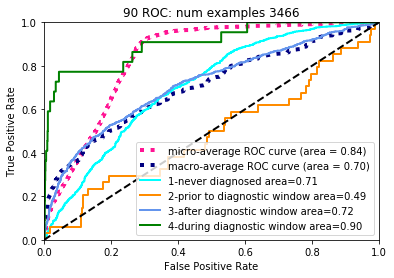

study 17179 76/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


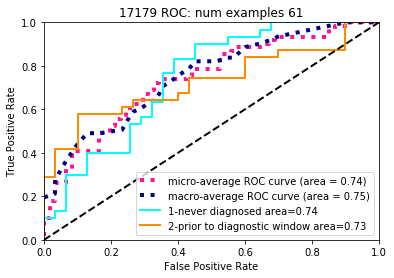

study 96 77/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


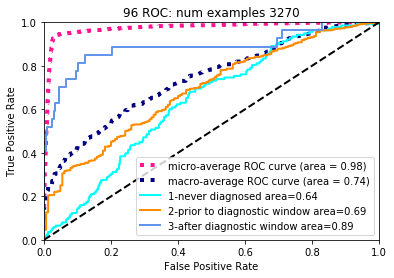

study 562 78/168


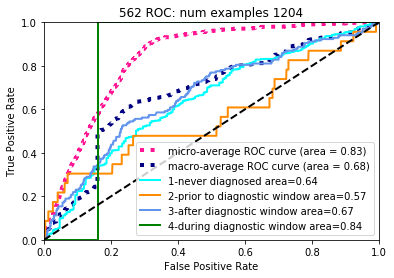

study 4566 79/168


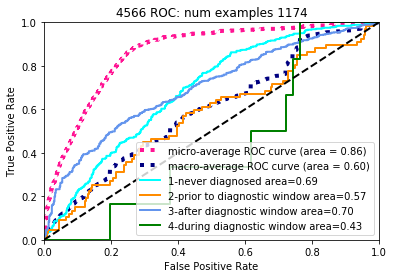

study 414 80/168


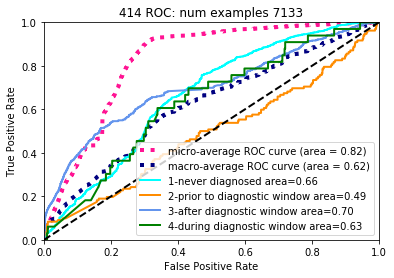

study 2169 81/168


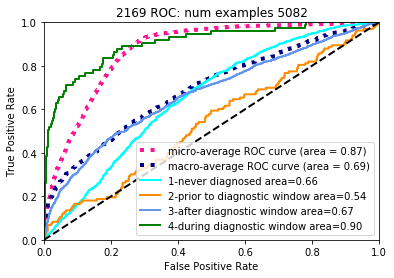

study 1360 82/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


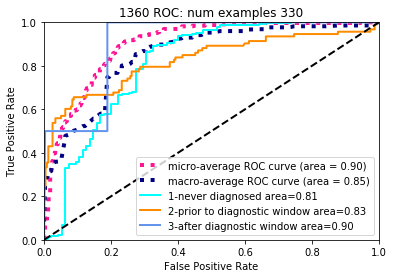

study 631 83/168


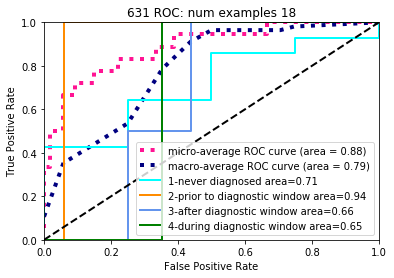

study 2164 84/168


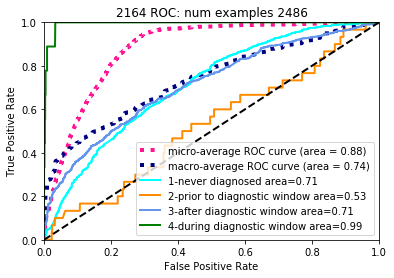

study 2228 85/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


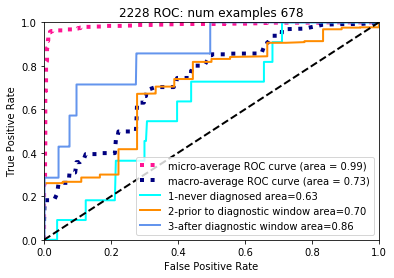

study 624 86/168


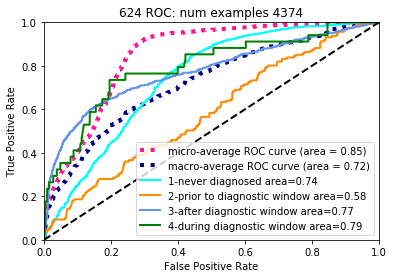

study 314c0838-3f0a-4a06-8aae-c3aefa581bf6 87/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


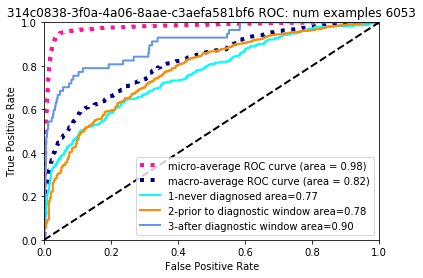

study 2153 88/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


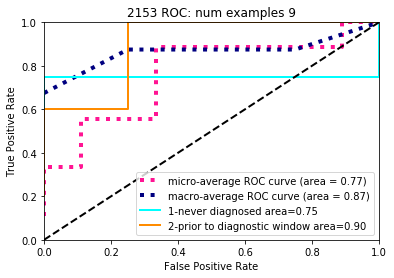

study 7580 89/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


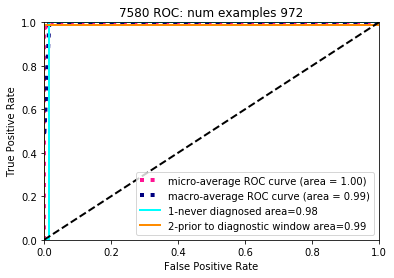

study 1534 90/168


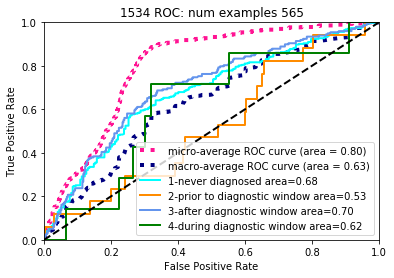

study 2134 91/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


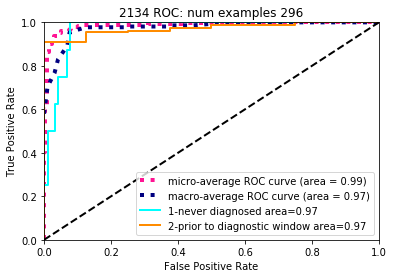

study 2106 92/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


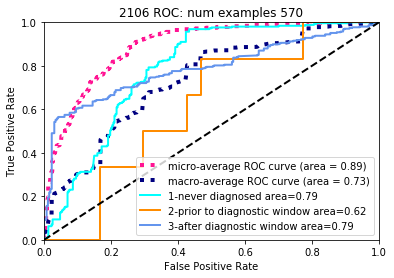

study 1685 93/168


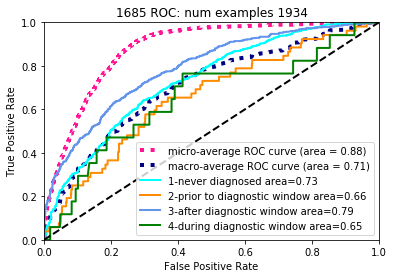

study 197 94/168


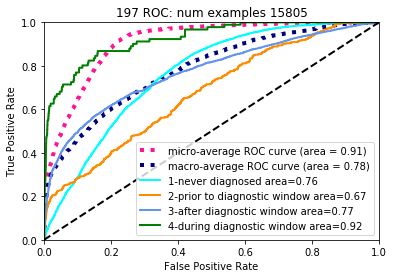

study 1060 95/168


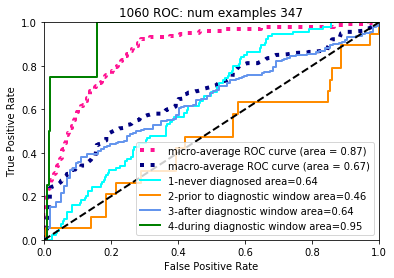

study 583 96/168


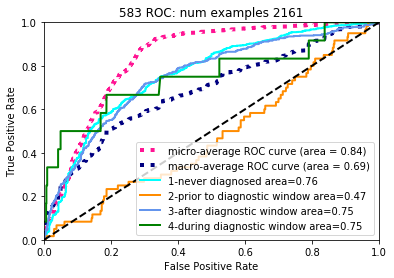

study 86 97/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


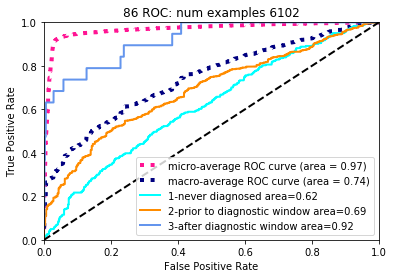

study 5862 98/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


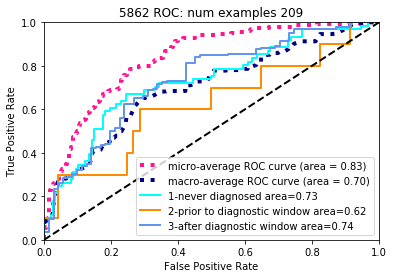

study 2292 99/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


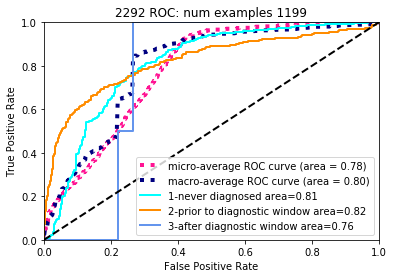

study 4334 100/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


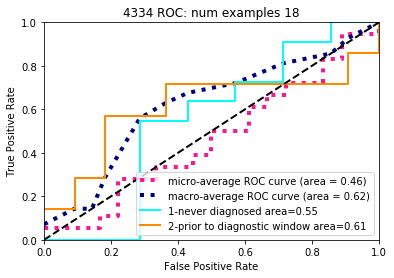

study 676 101/168


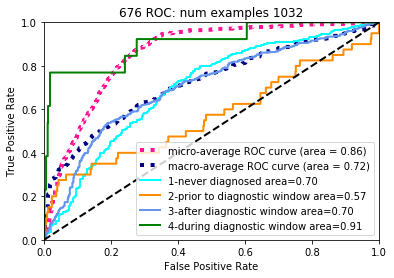

study 7587 102/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


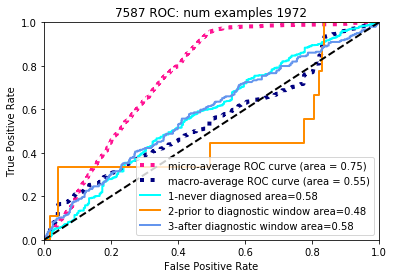

study 1577 103/168


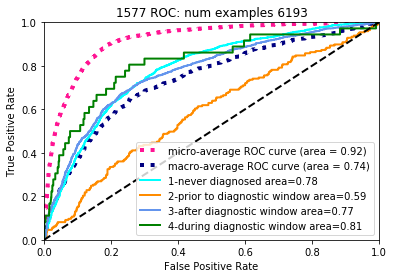

study 2263 104/168


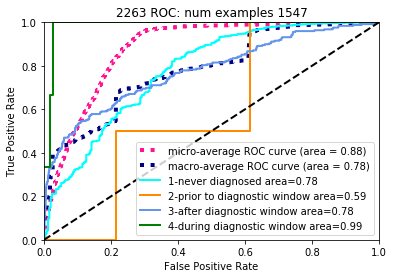

study 1624 105/168
dropped 3 classes because there were no positive examples in labels (ROC undefined in this case)


/home/noel/tensorflow/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/noel/tensorflow/lib/python3.5/site-packages/sklearn/metrics/ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


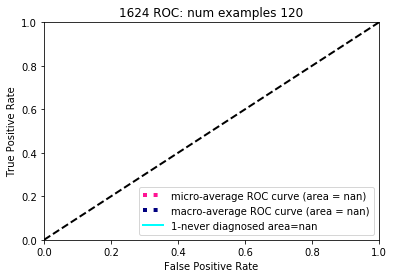

study 829 106/168


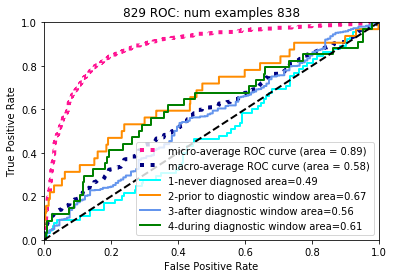

study 1776 107/168
dropped 3 classes because there were no positive examples in labels (ROC undefined in this case)


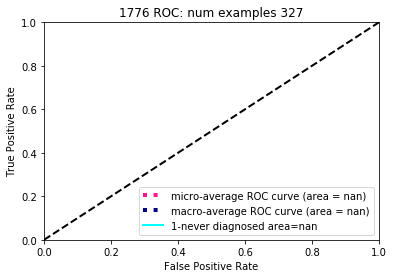

study c879ac8f-a8ee-4f40-b665-7faef159746c 108/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


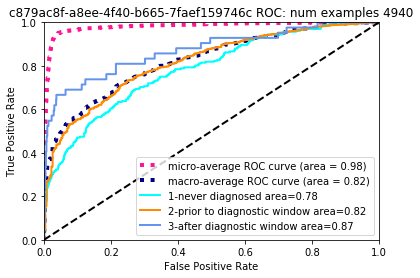

study 15219 109/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


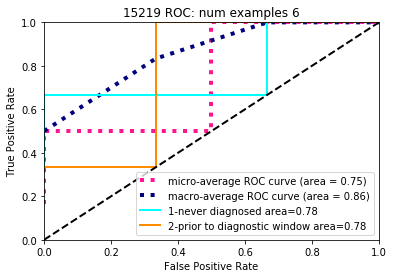

study 1678 110/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


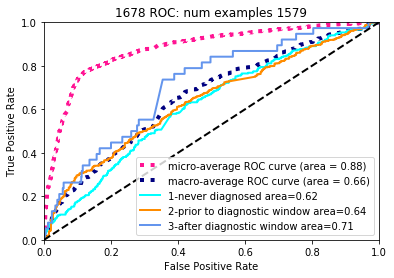

study 1338 111/168


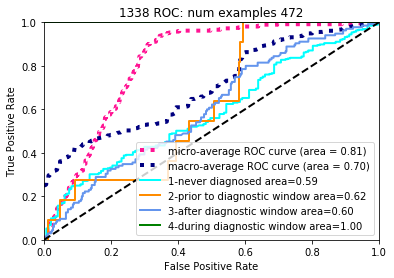

study 7028 112/168


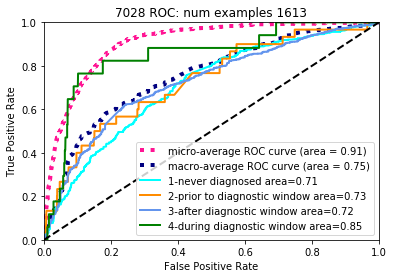

study 891 113/168


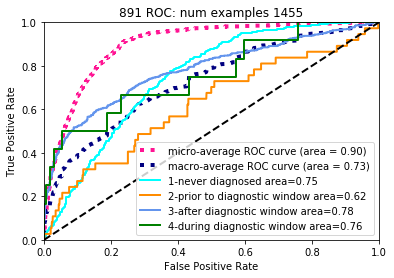

study 1760 114/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


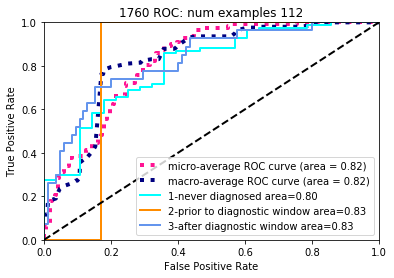

study 5b4196d1-ecbf-4895-9cff-822b84203509 115/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


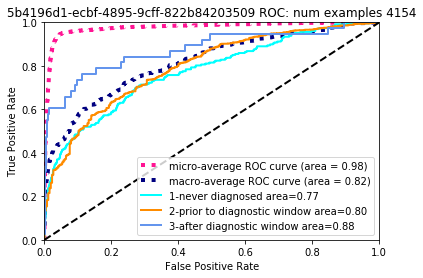

study 1313 116/168


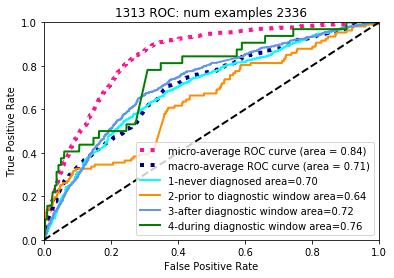

study 7890 117/168


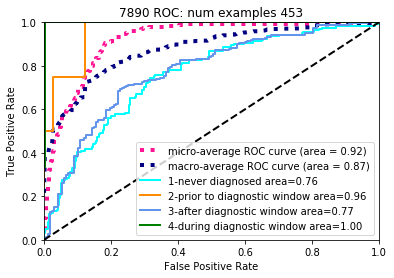

study 1097 118/168


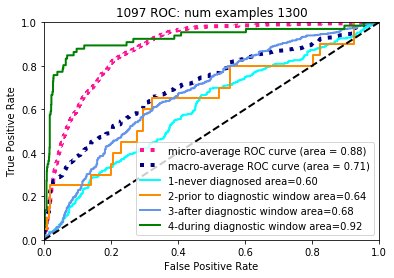

study 1096 119/168


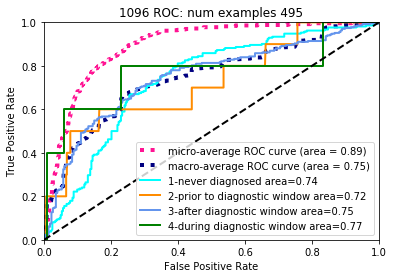

study b0a61acd-b4cb-4f54-b294-95effb485245 120/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


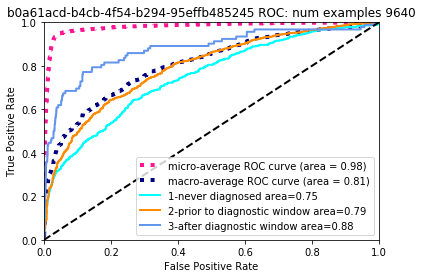

study 648 121/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


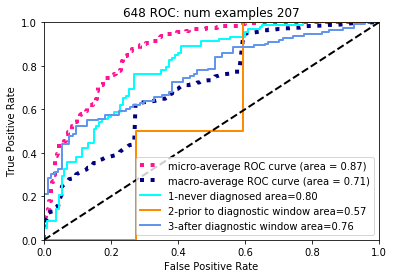

study 84 122/168


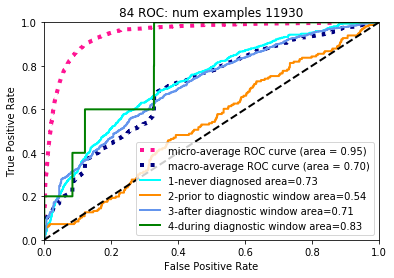

study 1074 123/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


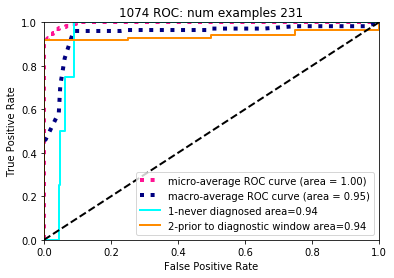

study 668 124/168


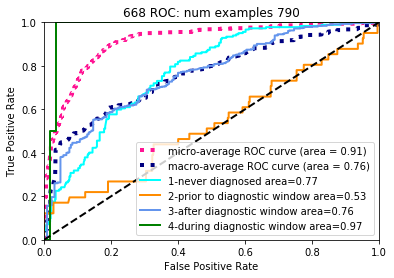

study 7550 125/168


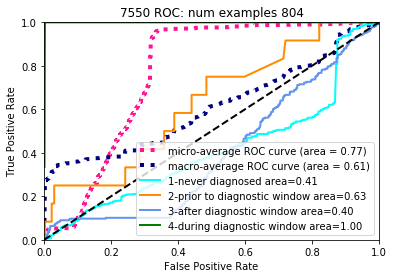

study 1914 126/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


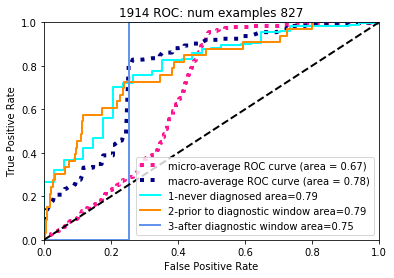

study 7604 127/168


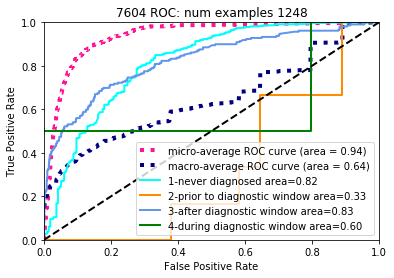

study 85d2a38e-e0ae-464f-8d5a-001b4d303e15 128/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


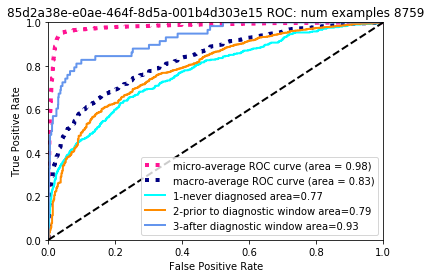

study 1779 129/168


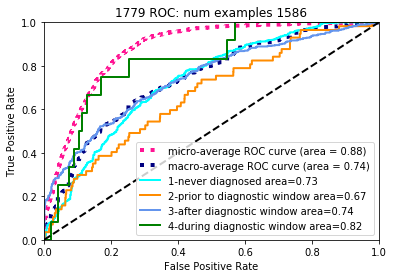

study 1609 130/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


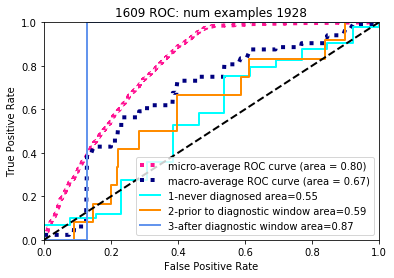

study 889 131/168


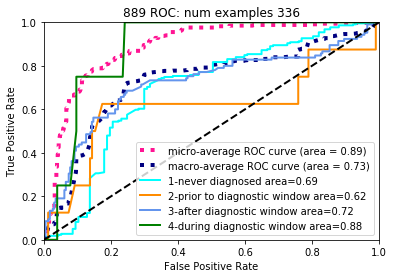

study 967 132/168


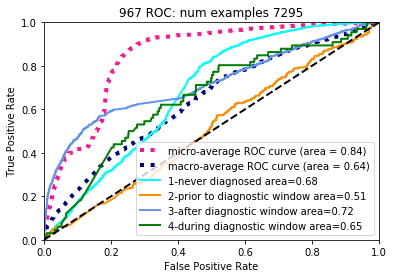

study 1063 133/168


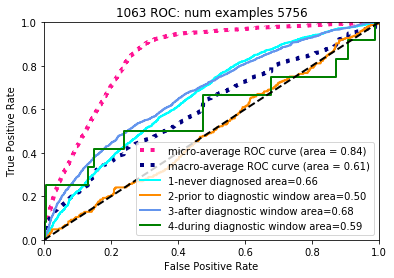

study 312 134/168


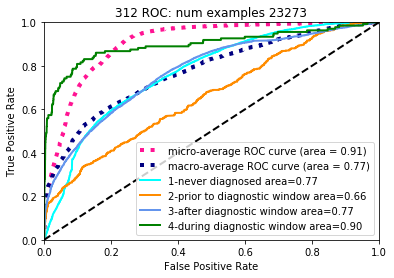

study 1849 135/168


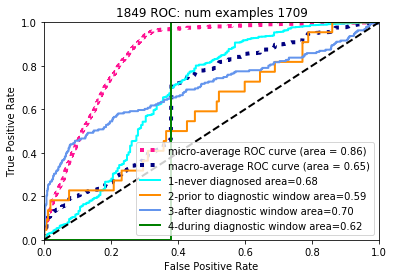

study 740 136/168


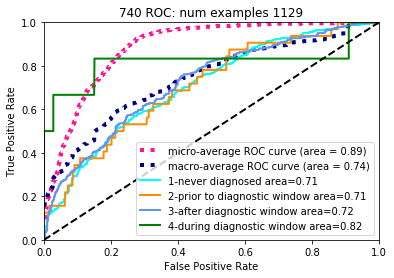

study 2019 137/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


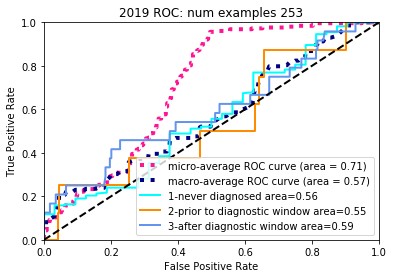

study 1751 138/168


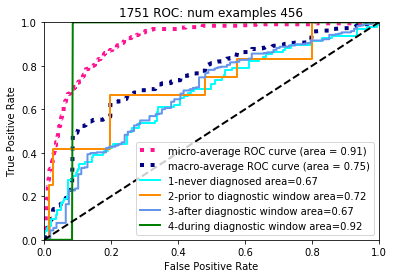

study 593 139/168


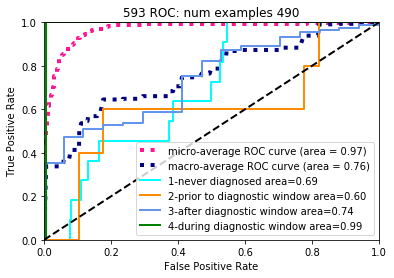

study 1658 140/168


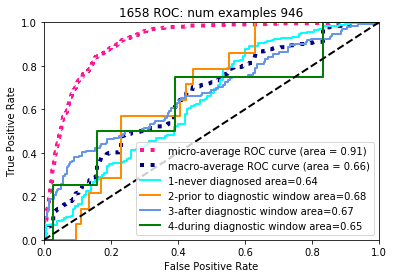

study 103 141/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


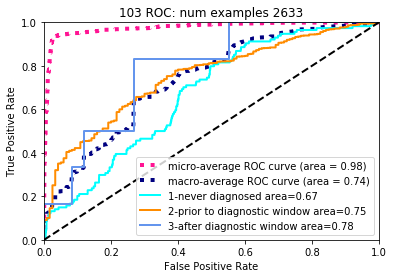

study 98 142/168


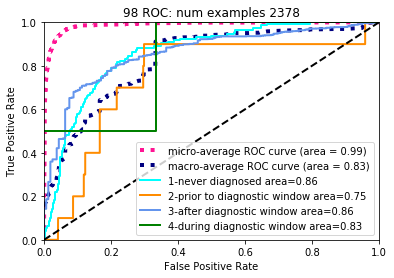

study 594 143/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


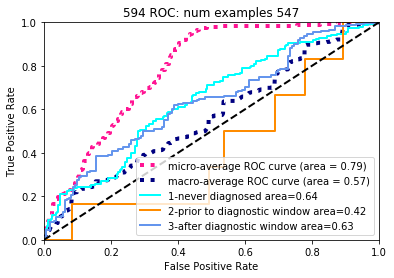

study 979 144/168


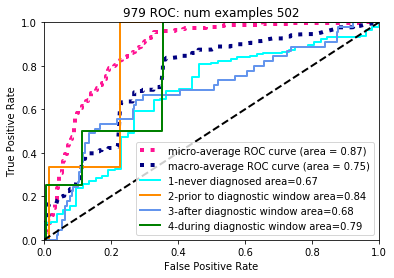

study 19783 145/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


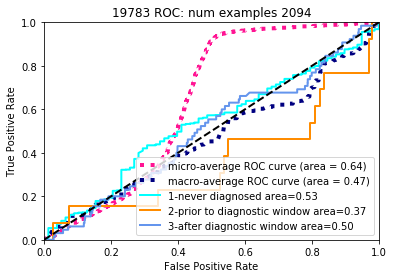

study 425 146/168


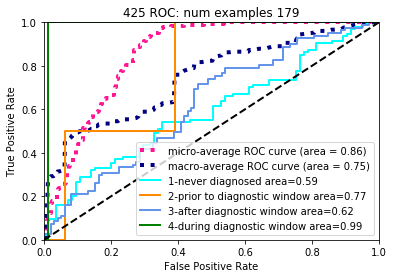

study 5400 147/168


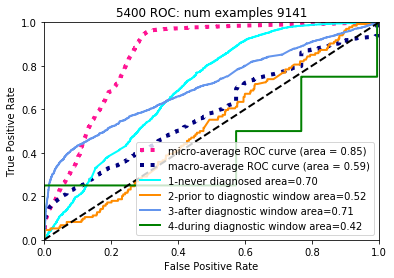

study 2187 148/168


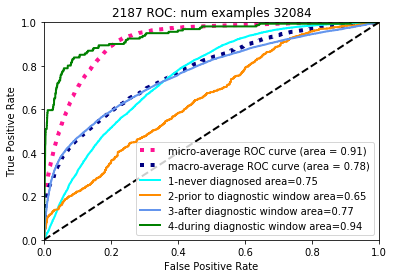

study 952 149/168


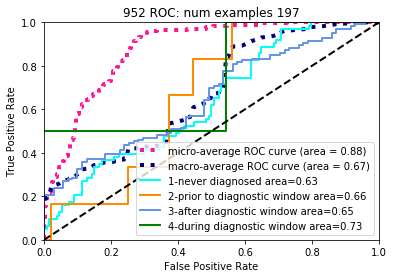

study 1014 150/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


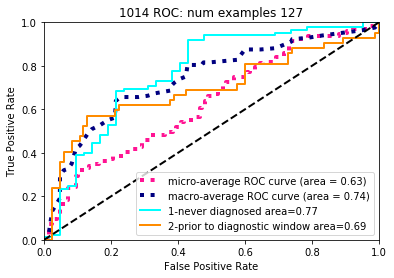

study bc030e37-1838-473c-a854-1300febca9e1 151/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


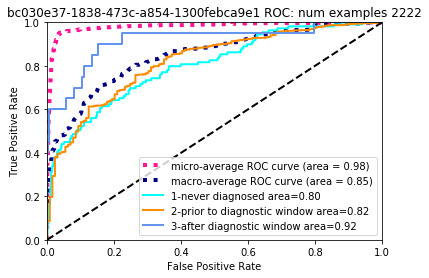

study 2255 152/168


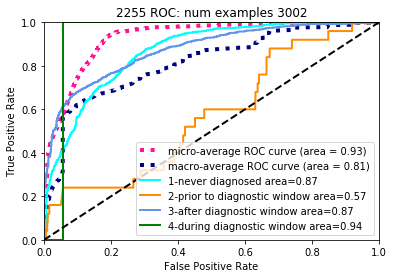

study 11013 153/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


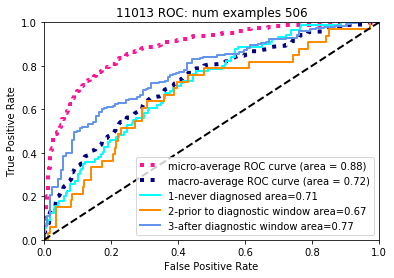

study 396 154/168
dropped 3 classes because there were no positive examples in labels (ROC undefined in this case)


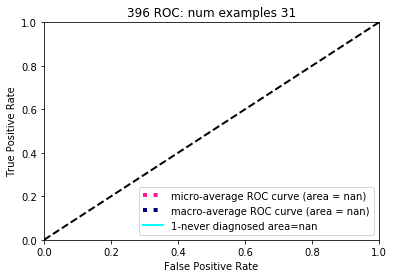

study 560 155/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


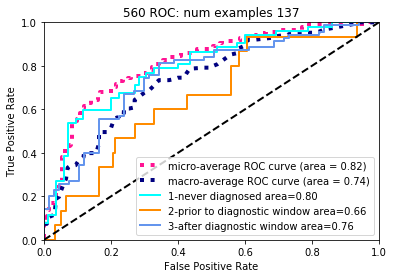

study 7514 156/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


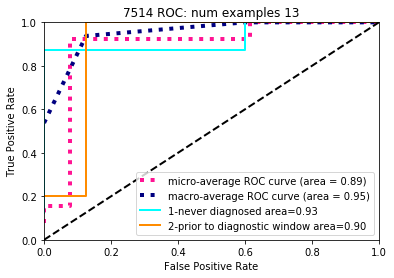

study 1150 157/168


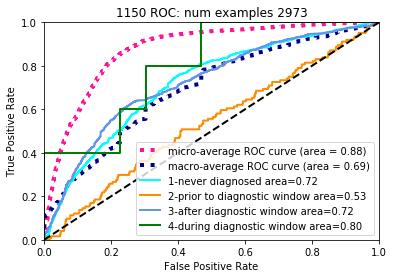

study 1503 158/168
dropped 2 classes because there were no positive examples in labels (ROC undefined in this case)


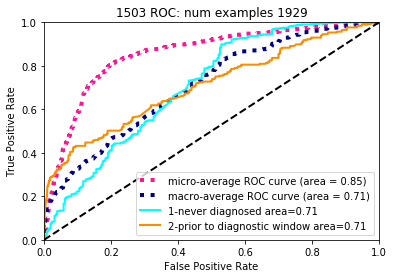

study 2242 159/168


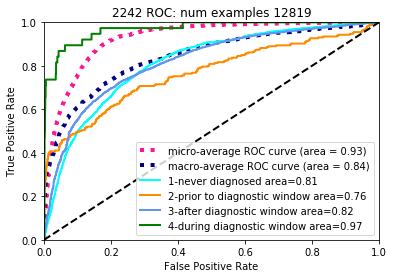

study 2206 160/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


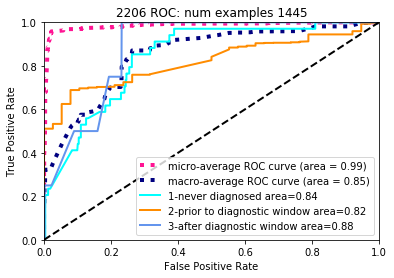

study e3acc57b-584f-4290-92de-32242526ef77 161/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


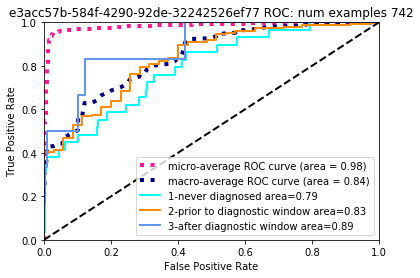

study 1473 162/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


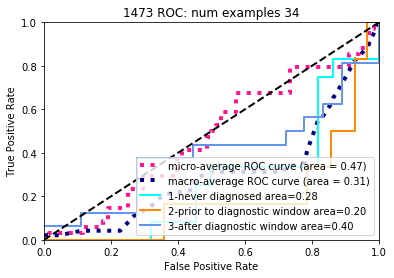

study 178 163/168


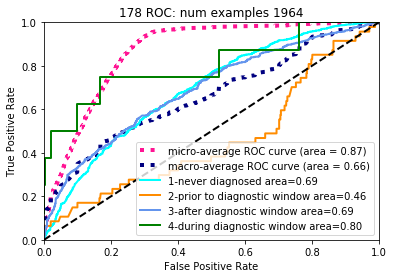

study 1785 164/168


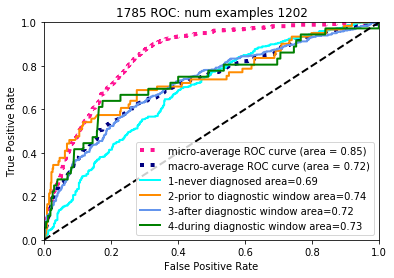

study 529 165/168


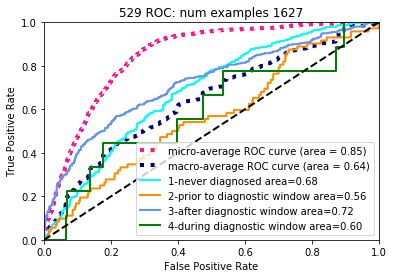

study 1046 166/168
dropped 1 classes because there were no positive examples in labels (ROC undefined in this case)


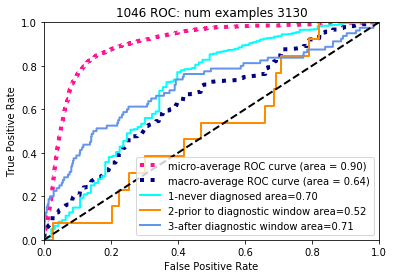

study 4756 167/168


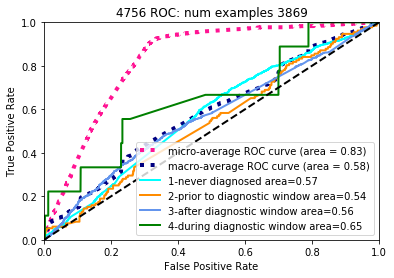

study 2176 168/168


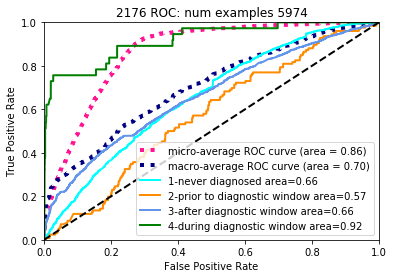

In [7]:
# train & evaluate
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from scipy import interp
from scipy.sparse import vstack,hstack
import json
import os.path
import random


def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]


study_rocuac={} # study per-class rocauc scores
study_indices={} # studyid -> y_pred/y_true indices
y_pred_cum=np.zeros((0,4))
y_true_cum=np.zeros((0,4))


# detect if we are resuming
if os.path.isfile('%s/heldout_disease_roc_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name)):
    # we are resuming, restore state
    
    # per study roc results
    with open('%s/heldout_disease_roc_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name), 'r') as file:
        study_rocuac=json.load(file)
    
    # dev pred/test indices in y_true/y_pred for each study
    with open('%s/study_sentence_dictionary_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name), 'r') as file:
        study_indices=json.load(file)


    # cumulative y_true results for each study so far. study_indices tells you indices for each study
    y_true_cum=np.load('%s/heldout_disease_y_true_cum_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name))

    # cumulative y_pred results for each study. study_indices tells you indices for each study
    y_pred_cum=np.load('%s/heldout_disease_y_pred_cum_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name))

    study_counter=len(study_rocuac)
    
# loop studies randomly, training and eval as we go
blarp=list(study_sentence_dictionary_train.items())
random.shuffle(blarp)
study_counter=len(study_rocuac)
print('loaded persisted results for %s studies' % study_counter)

for studyid,index_study_train in blarp:

    if studyid in study_rocuac:
        continue
        
    study_counter+=1  
    print('study %s %s/%s' % (studyid,study_counter,len(study_sentence_dictionary_train)))
    
    # create a training set that doesnt have study in it
    x_train_study,y_train_study=(
        delete_rows_csr(x_train,index_study_train)
        ,np.delete(y_train_4_class,index_study_train,axis=0)
    )
    
    # create an eval set that only has study in it
    x_test_study,y_test_study,y_test_study_one_hot=1,1,1
    
    
    if studyid in study_sentence_dictionary_test:
        # we have examples in test set:merge train and test
        index_study_test=study_sentence_dictionary_test[studyid]

        # then append the study examples in the training set to the test set
        x_test_study=vstack([x_test[index_study_test],x_train[index_study_train]])
        y_test_study=hstack([y_test_4_class[index_study_test],y_train_4_class[index_study_train]]).toarray()
        y_test_study_one_hot=np.vstack([
             y_test_4_class_one_hot[index_study_test,:]
            ,y_train_4_class_one_hot[index_study_train,:]])
        
    else:
        # no examples in test set, just use the examples from the original training set
        x_test_study=x_train[index_study_train]
        y_test_study=y_train_4_class[index_study_train]
        y_test_study_one_hot=y_train_4_class_one_hot[index_study_train,:]

    y_test_study=np.squeeze(y_test_study)
   
    # create model and fit
    svm = LinearSVC(C=C)
    svm.fit(x_train_study,y_train_study)
    
    # eval
    y_pred=svm.decision_function(x_test_study)
    y_true=y_test_study_one_hot
    roc_auc=evaluate(y_true,y_pred,plot=True,title='%s ROC: num examples %s' % (studyid,y_true.shape[0]))
    
    # store results
    study_rocuac[studyid]=roc_auc
    
    # calc indices of this study
    current_index=y_pred_cum.shape[0]
    number_of_predictions=y_pred.shape[0]
    study_indices[studyid]=list(range(current_index,current_index+number_of_predictions))
    
    # store true and predictions
    y_pred_cum=np.concatenate([y_pred_cum,y_pred],axis=0)
    y_true_cum=np.concatenate([y_true_cum,y_true],axis=0)
    

    # persist results so far
    with open('%s/heldout_disease_roc_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name), 'w') as file:
        json.dump(study_rocuac, file)
    with open('%s/study_sentence_dictionary_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name), 'w') as file:
        json.dump(study_indices, file)
    np.save('%s/heldout_disease_y_true_cum_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name),y_true_cum)
    np.save('%s/heldout_disease_y_pred_cum_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name),y_pred_cum)
    





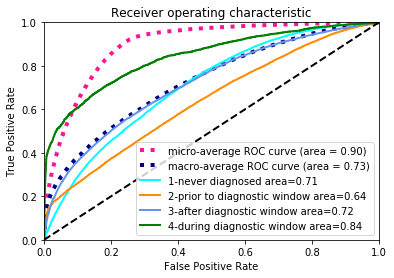

168


In [8]:
evaluate(y_true_cum, y_pred_cum)
print(len(study_rocuac))